### 1. Import Necessary Libraries

In [1]:
from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
# Setting random seed to 42 because we get consistent result between runs
np.random.seed(42)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### UMICH SI650 - Sentiment Classification

- umich-sentiment-train.txt & umich-sentiment-test.txt are the datasets.
- The dataset has around 7000 sentences and is labeled 1 for positive and 0 for negative.

### 2. Initialize basic variables

**Note: ** **Words** are called **tokens** and the process of splitting text into tokens is called tokenization.
1. vocab_size -> We will consider only 5000 words(tokens) in the text.
2. EMBED_SIZE setting -> is the size of the embedding that will be generated by the embedding layer.
3. NUM_FILTERS -> is the number of convolution filters we will train for our convolution layer.
4. NUM_WORDS ->is the size of each filter, that is, how many words we will convolve at a time.
5. BATCH_SIZE -> number of records to feed the network each time
6. NUM_EPOCHS -> number of records to feed the network each time and how many times we will run through the entire dataset during training:

In [2]:
INPUT_FILE = "./data/umich-sentiment-train.txt"
VOCAB_SIZE = 5000
EMBED_SIZE = 100
NUM_FILTERS = 256
NUM_WORDS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 20

### 2. We construct vocabulary out of most frequent words in the corpus(well formatted text)

In [23]:
counter = collections.Counter() #  dictionary containing keys and counts
fin = open(INPUT_FILE, "r",encoding="utf8")
maxlen = 0
for line in fin:
    _, sent = line.strip().split("\t") # 1st argument neglected, only 2nd argument is send to sent(sentence)
    words = [x.lower() for x in nltk.word_tokenize(sent)]  # Splitting the sentence into words
    
    # ['oh', ',', 'and', 'brokeback', 'mountain', 'was', 'a', 'terrible', 'movie', '.']
    # len(words) -->10
    if len(words) > maxlen: # words --> contains array of words in a sentence that is splitted
        maxlen = len(words)
    for word in words:
        counter[word] += 1 # counter-> A dictionary store how many time a word appears in the whole test for "The:7"
        # "The" --> Occurs seven times
fin.close()



In [24]:
word2index = collections.defaultdict(int)
# defaultdict means that if a key is not found in the dictionary, 
# then instead of a KeyError being thrown, a new entry is created.
print(word2index)

defaultdict(<class 'int'>, {})


In [48]:
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

In [19]:
xs, ys = [], []
fin = open(INPUT_FILE, "r",encoding="utf8")
for line in fin:
    label, sent = line.strip().split("\t")
    ys.append(int(label))
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    wids = [word2index[word] for word in words]
    xs.append(wids)
fin.close()
X = pad_sequences(xs, maxlen=maxlen)
Y = np_utils.to_categorical(ys)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, 
                                                random_state=42)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(4960, 42) (2126, 42) (4960, 2) (2126, 2)


In [20]:
model = Sequential()
model.add(Embedding(vocab_sz, EMBED_SIZE, input_length=maxlen))
#model.add(SpatialDropout1D(Dropout(0.2)))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(Xtest, Ytest))              


Train on 4960 samples, validate on 2126 samples
Epoch 1/20
4960/4960 [==============================] - 8s 2ms/step - loss: 0.2688 - acc: 0.9065 - val_loss: 0.0386 - val_acc: 0.9849
Epoch 2/20
4960/4960 [==============================] - 7s 1ms/step - loss: 0.0182 - acc: 0.9935 - val_loss: 0.0213 - val_acc: 0.9929
Epoch 3/20
4960/4960 [==============================] - 7s 1ms/step - loss: 0.0054 - acc: 0.9986 - val_loss: 0.0192 - val_acc: 0.9939
Epoch 4/20
4960/4960 [==============================] - 7s 1ms/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0181 - val_acc: 0.9934
Epoch 5/20
4960/4960 [==============================] - 7s 1ms/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0171 - val_acc: 0.9934
Epoch 6/20
4960/4960 [==============================] - 7s 1ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0175 - val_acc: 0.9944
Epoch 7/20
4960/4960 [==============================] - 7s 1ms/step - loss: 8.2029e-04 - acc: 0.9998 - val_loss: 0.0174 - val_acc: 0.9939
Epoch 8/20

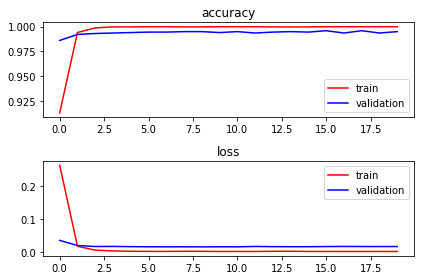

2126/2126 [==============================] - 1s 279us/step
Test score: 0.016, accuracy: 0.995


In [6]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# evaluate model
score = model.evaluate(Xtest, Ytest, verbose=1)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

[0.015980887329493074, 0.9948259642521167]
